In [1]:
# Import necessary libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output 


## Environment Definition








An environment is defined for the **Connect 4** game, including key functionalities to simulate matches, evaluate strategic positions, and develop intelligent agents.

#### Main Features

- **Board Management**: Initialization, reset, and representation of the current game state.
- **Winner Detection**: Identification of horizontal, vertical, and diagonal victories.
- **Strategic Evaluation**: Detailed analysis of the board to optimize player decisions.

#### Reward System

The reward system is designed to promote a balance between offensive and defensive strategies:

- **Center Control**: **+3 points per piece** placed in the center column, recognizing its strategic importance.

- **Winning Patterns**:
  - 4 consecutive pieces: **+100 points** (maximum reward).
  - 3 consecutive pieces with 1 free space: **+5 points**.
  - 2 consecutive pieces with 2 free spaces: **+2 points**.
  
- **Penalties**: **-4 points** are deducted if the opponent has 3 consecutive pieces with 1 free space.

This design encourages decisions that maximize winning opportunities while mitigating defensive risks, creating an optimal environment for the development and training of intelligent agents.


In [2]:
import numpy as np
from collections import defaultdict
import random
import pickle  

class Connect4:
    """
    Implementation of the Connect4 game environment
    Represents the game board and game logic.
    """
    def __init__(self):
        # Initialize the 6x7 board with zeros (empty spaces)
        self.board = np.zeros((6, 7))
        
    def reset(self):
        """Resets the game board to the initial state"""
        self.board = np.zeros((6, 7))
        return self.get_state()
    
    def get_valid_moves(self):
        """Returns a list of columns where a piece can be placed"""
        return [col for col in range(7) if self.board[0][col] == 0]
    
    def make_move(self, col, player):
        """
        Places a piece in the specified column for the given player
        Returns True if successful, False if the column is full
        """
        for row in range(5, -1, -1):
            if self.board[row][col] == 0:
                self.board[row][col] = player
                return True
        return False

    def check_winner(self):
        """
        Checks if there is a winner
        Returns: 1 if Player 1 wins, 2 if Player 2 wins, 0 if there is no winner
        """
        # Check horizontal wins
        for row in range(6):
            for col in range(4):
                window = self.board[row, col:col+4]
                if np.all(window == 1): return 1
                if np.all(window == 2): return 2

        # Check vertical wins
        for row in range(3):
            for col in range(7):
                window = self.board[row:row+4, col]
                if np.all(window == 1): return 1
                if np.all(window == 2): return 2

        # Check diagonal wins (bottom-left to top-right)
        for row in range(3):
            for col in range(4):
                window = [self.board[row+i][col+i] for i in range(4)]
                if all(x == 1 for x in window): return 1
                if all(x == 2 for x in window): return 2

        # Check reverse diagonal wins (top-left to bottom-right)
        for row in range(3):
            for col in range(3, 7):
                window = [self.board[row+i][col-i] for i in range(4)]
                if all(x == 1 for x in window): return 1
                if all(x == 2 for x in window): return 2

        return 0

    def get_state(self):
        """
        Converts the board state into a string representation for Q-table lookup
        Returns: String representing the current board state
        """
        state = []
        for row in range(6):
            for col in range(7):
                state.append(str(int(self.board[row][col])))
        return ''.join(state)

    def evaluate_state(self):
        """
        Evaluates the current board state
        Returns a numerical score representing how favorable the position is for Player 1
        """
        score = 0
        
        # Reward for controlling the center column
        center_array = [int(self.board[i][3]) for i in range(6)]
        center_count = center_array.count(1)
        score += center_count * 3

        # Evaluate patterns for both players
        for player in [1, 2]:
            # Multiplier: positive for the agent, negative for the opponent
            multiplier = 1 if player == 1 else -1
            
            # Check all possible windows (horizontal, vertical, diagonal)
            # Horizontal check
            for row in range(6):
                for col in range(4):
                    window = list(self.board[row, col:col+4])
                    score += self.evaluate_window(window, player) * multiplier

            # Vertical check
            for row in range(3):
                for col in range(7):
                    window = list(self.board[row:row+4, col])
                    score += self.evaluate_window(window, player) * multiplier

            # Diagonal check
            for row in range(3):
                for col in range(4):
                    window = [self.board[row+i][col+i] for i in range(4)]
                    score += self.evaluate_window(window, player) * multiplier

            # Reverse diagonal check
            for row in range(3):
                for col in range(3, 7):
                    window = [self.board[row+i][col-i] for i in range(4)]
                    score += self.evaluate_window(window, player) * multiplier

        return score

    def evaluate_window(self, window, player):
        """
        Scores a window of 4 positions
        Higher scores for more pieces in a row
        """
        score = 0
        opp_player = 3 - player
        
        # Maximum score for a winning window
        if window.count(player) == 4:
            score += 100
        # High score for three in a row with one empty space
        elif window.count(player) == 3 and window.count(0) == 1:
            score += 5
        # Low score for two in a row with two empty spaces
        elif window.count(player) == 2 and window.count(0) == 2:
            score += 2
            
        # Penalty for opponent's three in a row
        if window.count(opp_player) == 3 and window.count(0) == 1:
            score -= 4
            
        return score


#### Q-Learning Agent for Connect 4

A **Q-Learning**-based agent is defined to learn how to play **Connect 4** through experience. It uses a Q-table to map states and actions, combining Q-values with board evaluations.

##### Features

- **Exploration and Exploitation**: Implements an epsilon-greedy strategy.
- **Q-value Updates**: Based on immediate and future rewards.
- **Persistence**: Supports saving and loading the Q-table.


In [3]:
import numpy as np
from collections import defaultdict
import random
import pickle

class QLearningAgent:
    """
    Implementation of a Q-Learning-based agent
    Learns to play Connect 4 through experience
    """
    def __init__(self, epsilon=0.1, alpha=0.1, gamma=0.95):
        # Q-table: Maps state-action pairs to values
        self.q_table = defaultdict(lambda: np.zeros(7))
        self.epsilon = epsilon  # Exploration rate
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        
    def get_action(self, state, valid_moves, env):
        """
        Selects an action using the epsilon-greedy strategy
        Combines Q-values with immediate board evaluation
        """
        # Exploration: choose a random move
        if random.random() < self.epsilon:
            return random.choice(valid_moves)
        
        # Exploitation: best move based on Q-values and board evaluation
        action_values = []
        for action in valid_moves:
            # Copy the board to simulate the move
            temp_board = env.board.copy()
            # Simulate the move for player 1
            for row in range(5, -1, -1):
                if temp_board[row][action] == 0:
                    temp_board[row][action] = 1
                    break
            # Create a temporary environment to evaluate the state
            temp_env = Connect4()
            temp_env.board = temp_board
            # Evaluate the state
            value = temp_env.evaluate_state() + self.q_table[state][action]
            action_values.append((action, value))
        
        # Return the action with the highest value
        return max(action_values, key=lambda x: x[1])[0]

    def learn(self, state, action, reward, next_state, next_valid_moves, env):
        """
        Updates Q-values based on experience
        Uses the Q-Learning update rule combined with board evaluation
        """
        # Calculate the max Q-value for the next state
        if next_valid_moves:
            next_max = max([self.q_table[next_state][next_action] 
                          for next_action in next_valid_moves])
        else:
            next_max = 0
            
        # Combine immediate reward with board evaluation
        total_reward = reward + 0.1 * env.evaluate_state()
        
        # Q-Learning update formula
        old_value = self.q_table[state][action]
        new_value = (1 - self.alpha) * old_value + \
                   self.alpha * (total_reward + self.gamma * next_max)
        self.q_table[state][action] = new_value
    
    def save_q_table(self, filename):
        """
        Saves the Q-table to a file using pickle
        """
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
        print(f"Q-table saved in {filename}")

    def load_q_table(self, filename):
        """
        Loads the Q-table from a file using pickle
        """
        with open(filename, 'rb') as f:
            q_table_dict = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(7), q_table_dict)
        print(f"Q-table loaded from {filename}")


#### Training the Q-Learning Agent

The training process is defined in three phases:

1. **Against a random opponent** (40% of episodes).
2. **Against another Q-Learning agent** (30% of episodes).
3. **Self-play** (30% of episodes).

#### Metrics and Evaluation

- **Win rate**: Moving average of wins per phase.
- **Rewards**: Accumulated rewards per episode.
- **Episode duration**: Number of moves per episode.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time

def plot_training_metrics(metrics, rolling_window=100):
    """
    Plots training metrics for each phase.
    - Win rate: Moving average of win rates per episode.
    - Reward per episode: Cumulative reward per episode.
    - Episode length: Number of moves per episode.
    """
    phases = metrics.keys()
    
    for phase in phases:
        phase_data = metrics[phase]
        
        # Calculate the moving average of the win rate
        win_rate_history = phase_data["win_rate_history"]
        rolling_win_rate = np.convolve(win_rate_history, np.ones(rolling_window)/rolling_window, mode='valid')
        
        # Calculate the moving average of rewards
        rewards = phase_data["rewards"]
        rolling_rewards = np.convolve(rewards, np.ones(rolling_window)/rolling_window, mode='valid')
        
        # Calculate the moving average of episode lengths
        episode_lengths = phase_data["episode_lengths"]
        rolling_lengths = np.convolve(episode_lengths, np.ones(rolling_window)/rolling_window, mode='valid')
        
        # Plot win rate
        plt.figure(figsize=(8, 4))
        plt.plot(rolling_win_rate, label="Win Rate (Moving Average)")
        plt.title(f"Win Rate - Phase: {phase.upper()}")
        plt.xlabel("Episodes")
        plt.ylabel("Win Rate")
        plt.legend()
        plt.grid()
        plt.show()
        
        # Plot rewards
        plt.figure(figsize=(8, 4))
        plt.plot(rolling_rewards, label="Cumulative Reward")
        plt.title(f"Cumulative Reward - Phase: {phase.upper()}")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.legend()
        plt.grid()
        plt.show()
        
        # Plot episode lengths
        plt.figure(figsize=(8, 4))
        plt.plot(rolling_lengths, label="Episode Length")
        plt.title(f"Episode Length - Phase: {phase.upper()}")
        plt.xlabel("Episodes")
        plt.ylabel("Moves per Episode")
        plt.legend()
        plt.grid()
        plt.show()
        
        # Print phase statistics
        print(f"Statistics for Phase {phase.upper()}:")
        print(f"  - Duration: {phase_data['duration']:.2f} seconds")
        print(f"  - Reward: Min={np.min(phase_data['rewards'])}, Max={np.max(phase_data['rewards'])}, Average={np.mean(phase_data['rewards']):.2f}")
        print(f"  - Episode Length: Min={np.min(phase_data['episode_lengths'])}, Max={np.max(phase_data['episode_lengths'])}, Average={np.mean(phase_data['episode_lengths']):.2f}")
        print(f"  - Win Rate: {phase_data['wins'] / len(phase_data['rewards']):.2%}")

def train(episodes=10000, rolling_window=100):
    """
    Trains the Q-Learning agent in three phases:
    - 40% of episodes against a random opponent.
    - 30% of episodes against another Q-Learning agent.
    - 30% of episodes in self-play.
    
    Tracks and plots key metrics such as rewards, win rates, and episode durations.
    """
    env = Connect4()  # Initialize the Connect 4 environment
    agent = QLearningAgent(epsilon=0.1, alpha=0.1, gamma=0.95)
    opponent_agent = QLearningAgent(epsilon=0.1, alpha=0.1, gamma=0.95)
    
    # Thresholds for training phases
    random_opponent_threshold = int(0.3 * episodes)
    agent_opponent_threshold = int(0.7 * episodes)

    # Metrics for each phase
    metrics = {
        "random": {"wins": 0, "rewards": [], "episode_lengths": [], "win_rate_history": [], "duration": 0},
        "agent": {"wins": 0, "rewards": [], "episode_lengths": [], "win_rate_history": [], "duration": 0},
        "self": {"wins": 0, "rewards": [], "episode_lengths": [], "win_rate_history": [], "duration": 0},
    }
    
    for episode in range(episodes):
        start_time = time.time()
        state = env.reset()
        done = False
        player_turn = 1  # 1 for the agent, 2 for the opponent
        episode_reward = 0
        moves = 0
        
        # Determine the current phase
        if episode < random_opponent_threshold:
            phase = "random"
            opponent_type = "random"
        elif episode < agent_opponent_threshold:
            phase = "agent"
            opponent_type = "agent"
        else:
            phase = "self"
            opponent_type = "self"

        while not done:
            if player_turn == 1:
                valid_moves = env.get_valid_moves()
                if not valid_moves:
                    break
                # Agent's turn
                action = agent.get_action(state, valid_moves, env)
                env.make_move(action, player=1)
                
                # Evaluate the game's outcome
                winner = env.check_winner()
                if winner == 1:
                    reward = 100  # Win
                    done = True
                    metrics[phase]["wins"] += 1
                elif winner == 2:
                    reward = -100  # Loss
                    done = True
                elif not env.get_valid_moves():
                    reward = 0  # Draw
                    done = True
                else:
                    reward = env.evaluate_state()  # Intermediate state
                
                next_state = env.get_state()
                next_valid_moves = env.get_valid_moves()
                
                # Update the agent's Q-values
                agent.learn(state, action, reward, next_state, next_valid_moves, env)
                
                state = next_state  # Update the state
                player_turn = 2  # Switch to the opponent's turn
            else:
                # Opponent's turn
                valid_moves = env.get_valid_moves()
                if not valid_moves:
                    break
                if opponent_type == "random":
                    opponent_action = random.choice(valid_moves)
                elif opponent_type == "agent":
                    opponent_action = opponent_agent.get_action(state, valid_moves, env)
                else:  # Self-play
                    opponent_action = agent.get_action(state, valid_moves, env)
                
                env.make_move(opponent_action, player=2)
                
                winner = env.check_winner()
                if winner == 2:
                    reward = -100  # Loss
                    done = True
                elif not env.get_valid_moves():
                    reward = 0  # Draw
                    done = True
                
                state = env.get_state()
                player_turn = 1  # Switch to the agent's turn
            
            episode_reward += reward
            moves += 1
        
        # Log episode metrics
        metrics[phase]["rewards"].append(episode_reward)
        metrics[phase]["episode_lengths"].append(moves)
        
        # Update the win rate
        total_episodes = len(metrics[phase]["rewards"])
        win_rate = metrics[phase]["wins"] / total_episodes if total_episodes > 0 else 0
        metrics[phase]["win_rate_history"].append(win_rate)
        
        # Log the phase duration
        metrics[phase]["duration"] += time.time() - start_time
        
        # Display progress every 100 episodes
        if episode % 100 == 0:
            rolling_win_rate = np.mean(metrics[phase]["win_rate_history"][-rolling_window:])
            avg_reward = np.mean(metrics[phase]["rewards"][-rolling_window:])
            avg_length = np.mean(metrics[phase]["episode_lengths"][-rolling_window:])
            print(f"Episode {episode}, Phase: {phase.upper()}, "
                  f"Win Rate (Moving Average): {rolling_win_rate:.2%}, "
                  f"Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}, "
                  f"Epsilon: {agent.epsilon:.4f}")
    
    # Plot metrics for each phase
    plot_training_metrics(metrics, rolling_window)
    
    return agent


Episode 0, Phase: RANDOM, Win Rate (Moving Average): 100.00%, Avg Reward: 162.00, Avg Length: 7.00, Epsilon: 0.1000
Episode 100, Phase: RANDOM, Win Rate (Moving Average): 100.00%, Avg Reward: 212.18, Avg Length: 9.24, Epsilon: 0.1000
Episode 200, Phase: RANDOM, Win Rate (Moving Average): 100.00%, Avg Reward: 202.96, Avg Length: 8.80, Epsilon: 0.1000
Episode 300, Phase: RANDOM, Win Rate (Moving Average): 99.83%, Avg Reward: 199.04, Avg Length: 8.79, Epsilon: 0.1000
Episode 400, Phase: RANDOM, Win Rate (Moving Average): 99.66%, Avg Reward: 192.28, Avg Length: 8.59, Epsilon: 0.1000
Episode 500, Phase: RANDOM, Win Rate (Moving Average): 99.56%, Avg Reward: 185.84, Avg Length: 8.24, Epsilon: 0.1000
Episode 600, Phase: RANDOM, Win Rate (Moving Average): 99.64%, Avg Reward: 201.04, Avg Length: 8.98, Epsilon: 0.1000
Episode 700, Phase: RANDOM, Win Rate (Moving Average): 99.69%, Avg Reward: 198.60, Avg Length: 8.64, Epsilon: 0.1000
Episode 800, Phase: RANDOM, Win Rate (Moving Average): 99.73%, 

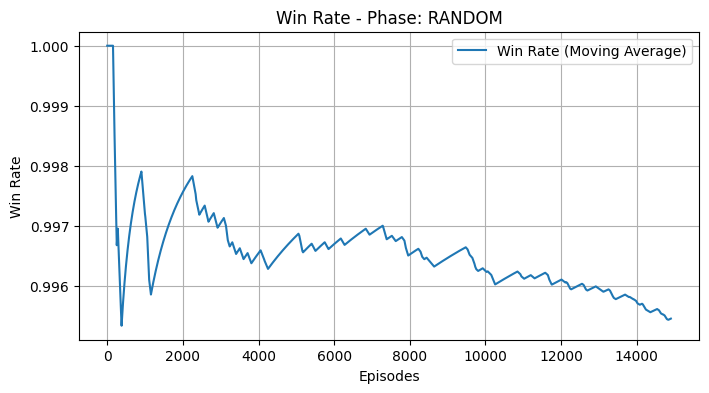

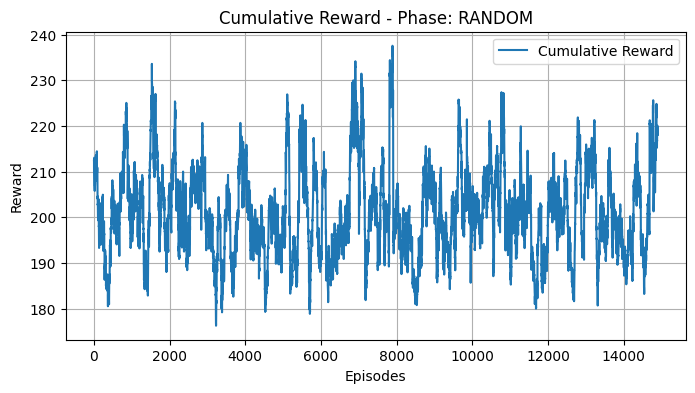

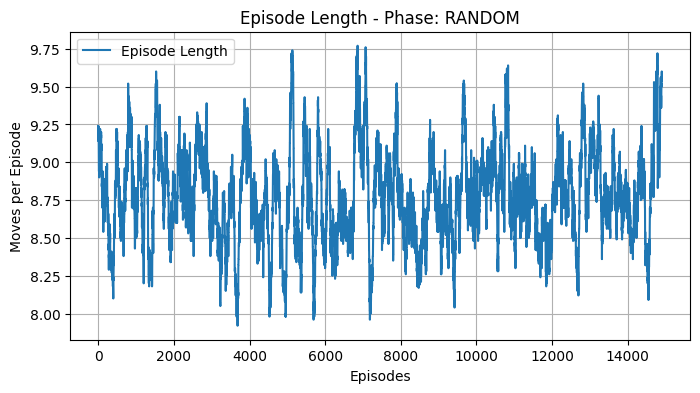

Statistics for Phase RANDOM:
  - Duration: 104.22 seconds
  - Reward: Min=-78, Max=2058, Average=201.19
  - Episode Length: Min=7, Max=33, Average=8.78
  - Win Rate: 99.55%


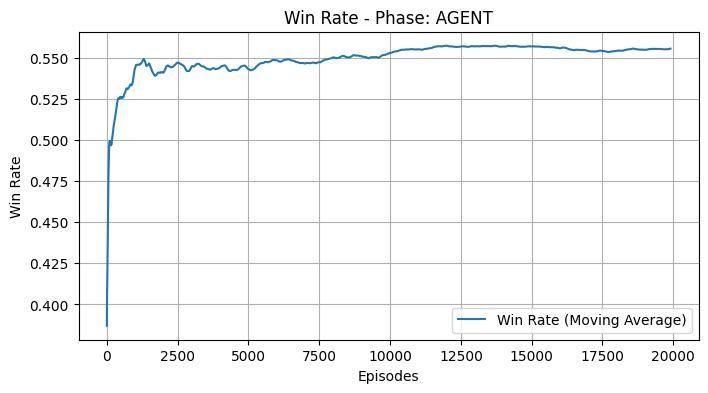

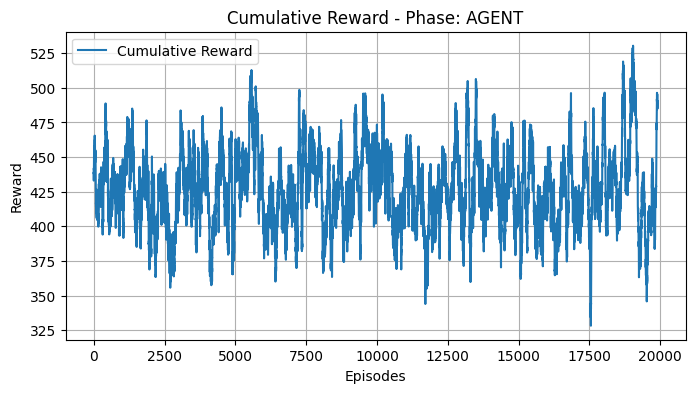

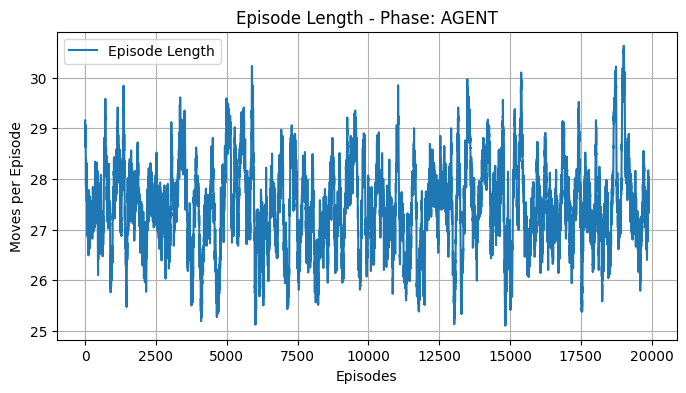

Statistics for Phase AGENT:
  - Duration: 567.19 seconds
  - Reward: Min=-546, Max=1990, Average=426.56
  - Episode Length: Min=7, Max=42, Average=27.46
  - Win Rate: 55.57%


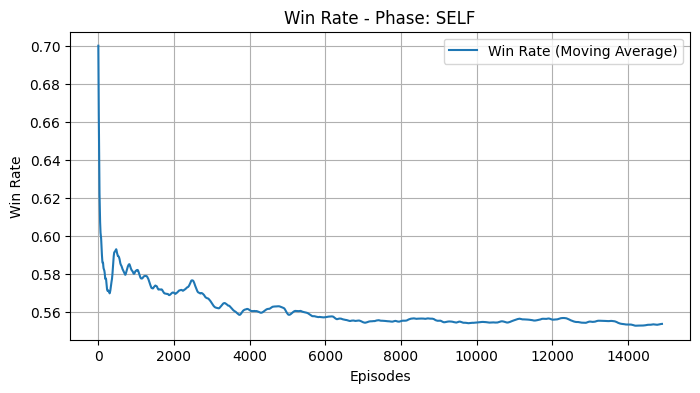

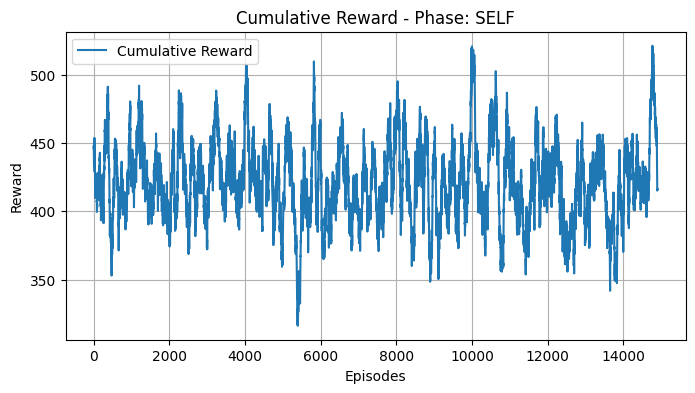

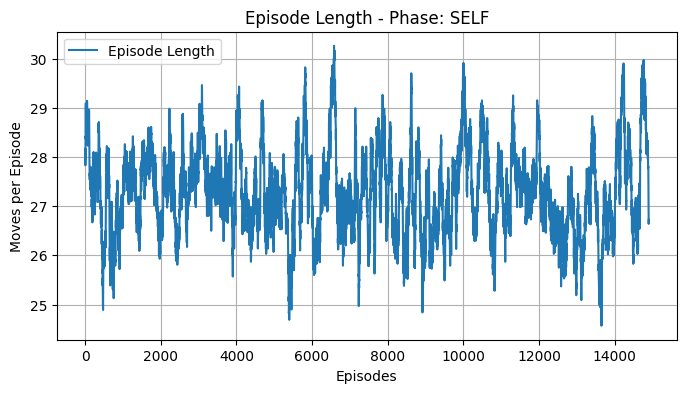

Statistics for Phase SELF:
  - Duration: 418.73 seconds
  - Reward: Min=-545, Max=1918, Average=420.99
  - Episode Length: Min=7, Max=42, Average=27.28
  - Win Rate: 55.35%
--- 1090.9843800067902 seconds ---


In [5]:
import time
start_time = time.time()
# Train the agent
agent = train(episodes=50000)
print("--- %s seconds ---" % (time.time() - start_time))

### Save and Load q-table

In [6]:
# Save the trained agent's Q-table
agent.save_q_table('q_table100000.pkl')

# Load the Q-table into a new agent
agent = QLearningAgent()
agent.load_q_table('q_table100000.pkl')

Q-table saved in q_table100000.pkl
Q-table loaded from q_table100000.pkl


### Demo trained agent 

1. Agente vs Random, 
2. Agente vs Agente
3. Agente vs Humano

In [7]:
from IPython.display import clear_output
import time

def print_board(env, stats=None, delay=None):
    
    clear_output(wait=True)  # Clear the previous output
    print("\nConnect 4")
    print("Agent 1 (X) vs Agent 2 (O)\n")
    
    # Display column numbers
    print(" 1  2  3  4  5  6  7")
    print("---------------------")
    
    # Display the board without flipping
    for row in env.board:  # Iterate from top to bottom
        print("|", end="")
        for cell in row:
            if cell == 0:
                print("   ", end="")  # Empty cell with consistent spacing
            elif cell == 1:
                print(" X ", end="")  # Player 1
            else:
                print(" O ", end="")  # Player 2
        print("|")
    print("---------------------")
    
    # Display stats if available
    if stats:
        print(f"\nStats - Agent 1: {stats.get('agent1_wins', 0)} wins, "
              f"Agent 2: {stats.get('agent2_wins', 0)} wins, "
              f"Draws: {stats.get('draws', 0)}")
    
    # Pause for the specified delay
    if delay:
        time.sleep(delay)

In [8]:
def visualize_agent_vs_random(agent, n_games=1, delay=1):
    env = Connect4()
    stats = {'agent_wins': 0, 'random_wins': 0, 'draws': 0}
    
    for game in range(n_games):
        state = env.reset()
        done = False
        player_turn = random.choice([1, 2])  # Randomly decide who starts
        
        while not done:
            # Print the current board and stats
            print_board(env, stats, delay)
            
            if player_turn == 1:
                # Agent's turn
                valid_moves = env.get_valid_moves()
                if not valid_moves:
                    stats['draws'] += 1
                    break
                action = agent.get_action(state, valid_moves, env)
                env.make_move(action, player=1)
                
                winner = env.check_winner()
                if winner == 1:
                    stats['agent_wins'] += 1
                    done = True
                elif winner == 2:
                    stats['random_wins'] += 1
                    done = True
                elif not env.get_valid_moves():
                    stats['draws'] += 1
                    done = True
                state = env.get_state()
                player_turn = 2  # Switch to random opponent
            else:
                # Random opponent's turn
                valid_moves = env.get_valid_moves()
                if not valid_moves:
                    stats['draws'] += 1
                    break
                action = random.choice(valid_moves)
                env.make_move(action, player=2)
                
                winner = env.check_winner()
                if winner == 2:
                    stats['random_wins'] += 1
                    done = True
                elif winner == 1:
                    stats['agent_wins'] += 1
                    done = True
                elif not env.get_valid_moves():
                    stats['draws'] += 1
                    done = True
                player_turn = 1  # Switch back to agent
        
        # Print the final board state
        print_board(env, stats, delay)
        print(f"Game {game + 1} finished. Press Enter to continue.")
        input()


In [9]:
def visualize_agent_vs_agent(agent1, agent2, n_games=1, delay=1):
    """
    Visualize agent vs agent games with live updates.
    
    Args:
        agent1: The first agent.
        agent2: The second agent.
        n_games (int): Number of games to visualize.
        delay (float): Delay between moves in seconds.
    """
    env = Connect4()
    stats = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}
    
    for game in range(n_games):
        state = env.reset()
        done = False
        player_turn = random.choice([1, 2])  # Randomly choose starting agent
        
        while not done:
            # Print the board and stats
            print_board(env, stats, delay)
            
            if player_turn == 1:
                # Agent1's turn
                valid_moves = env.get_valid_moves()
                if not valid_moves:
                    stats['draws'] += 1
                    break
                action = agent1.get_action(state, valid_moves, env)
                env.make_move(action, player=1)
                
                winner = env.check_winner()
                if winner == 1:
                    stats['agent1_wins'] += 1
                    done = True
                elif winner == 2:
                    stats['agent2_wins'] += 1
                    done = True
                elif not env.get_valid_moves():
                    stats['draws'] += 1
                    done = True
                state = env.get_state()
                player_turn = 2
            else:
                # Agent2's turn
                valid_moves = env.get_valid_moves()
                if not valid_moves:
                    stats['draws'] += 1
                    break
                action = agent2.get_action(state, valid_moves, env)
                env.make_move(action, player=2)
                
                winner = env.check_winner()
                if winner == 2:
                    stats['agent2_wins'] += 1
                    done = True
                elif winner == 1:
                    stats['agent1_wins'] += 1
                    done = True
                elif not env.get_valid_moves():
                    stats['draws'] += 1
                    done = True
                state = env.get_state()
                player_turn = 1
        
        # Final board state after game ends
        print_board(env, stats, delay)
        print(f"Game {game + 1} finished. Press Enter to continue.")
        input()


In [10]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def agent_vs_human_with_buttons(agent, player_first=True):
    """
    Play a game of Connect4 against the agent using interactive buttons.
    
    Args:
        agent: The trained Q-learning agent.
        player_first (bool): If True, the human goes first. If False, the agent goes first.
    """
    env = Connect4()
    state = env.reset()
    done = False
    player_turn = 2 if player_first else 1  # Set who goes first based on the parameter

    # Button widgets for column selection
    buttons = [widgets.Button(description=f"Col {i+1}") for i in range(7)]

    def display_game():
        clear_output(wait=True)
        print_board(env)  # Function to print the Connect4 board
        display(widgets.HBox(buttons))  # Display the buttons for user interaction
        print("\n" + ("Your turn (O)" if player_turn == 2 else "Agent's turn (X)"))

    def button_click(change):
        nonlocal player_turn, state, done

        # Human's turn: Process button clicks
        if player_turn == 2:
            col = int(change.description.split()[-1]) - 1  # Extract column number from button label
            if col in env.get_valid_moves():
                env.make_move(col, player=2)
                winner = env.check_winner()
                if winner == 2:
                    display_game()
                    print("Congratulations! You (O) win!")
                    done = True
                elif winner == 1:
                    display_game()
                    print("The Agent (X) wins! Better luck next time!")
                    done = True
                elif not env.get_valid_moves():
                    display_game()
                    print("It's a draw!")
                    done = True
                else:
                    state = env.get_state()
                    player_turn = 1  # Switch to Agent
                    display_game()
                    agent_turn()  # Trigger agent's turn

    def agent_turn():
        nonlocal player_turn, state, done
        if not done and player_turn == 1:
            action = agent.get_action(state, env.get_valid_moves(), env)
            env.make_move(action, player=1)
            winner = env.check_winner()
            if winner == 1:
                display_game()
                print("The Agent (X) wins! Better luck next time!")
                done = True
            elif winner == 2:
                display_game()
                print("Congratulations! You (O) win!")
                done = True
            elif not env.get_valid_moves():
                display_game()
                print("It's a draw!")
                done = True
            else:
                state = env.get_state()
                player_turn = 2  # Switch to Human
                display_game()

    # Attach click events to buttons
    for button in buttons:
        button.on_click(button_click)

    # Display the game board and buttons
    display_game()

    # If agent goes first, trigger agent's turn
    if player_turn == 1:
        agent_turn()


In [11]:
visualize_agent_vs_random(agent, n_games=2, delay=1)


Connect 4
Agent 1 (X) vs Agent 2 (O)

 1  2  3  4  5  6  7
---------------------
|                     |
|                     |
|                     |
|                     |
|          O          |
| O  X  X  X  X     O |
---------------------

Stats - Agent 1: 0 wins, Agent 2: 0 wins, Draws: 0
Game 2 finished. Press Enter to continue.


In [12]:
visualize_agent_vs_agent(agent, agent, n_games=2, delay=1)


Connect 4
Agent 1 (X) vs Agent 2 (O)

 1  2  3  4  5  6  7
---------------------
| O     X  O  O     X |
| O     O  X  X     O |
| X  O  X  X  O     X |
| O  X  X  O  X     O |
| O  O  O  X  O     X |
| X  X  O  O  X     X |
---------------------

Stats - Agent 1: 0 wins, Agent 2: 1 wins, Draws: 1
Game 2 finished. Press Enter to continue.


In [13]:
agent_vs_human_with_buttons(agent, player_first=True)



Connect 4
Agent 1 (X) vs Agent 2 (O)

 1  2  3  4  5  6  7
---------------------
|                     |
|                     |
|          O          |
|       O  X          |
|    X  X  X  X       |
| O  O  O  X  O       |
---------------------



Agent's turn (X)
The Agent (X) wins! Better luck next time!


### Q-tables analysis. 

Given a game state which are the q-values for each column

In [14]:
import numpy as np

def state_to_board(state):
    """
    Converts a state string to a Connect 4 board (6x7 numpy array).

    Args:
        state (str): The state string representing the board (42 characters).

    Returns:
        np.ndarray: A 6x7 numpy array representing the Connect 4 board.
    """
    if len(state) != 42:
        raise ValueError("State string must be 42 characters long.")
    
    # Convert the state string into a 1D numpy array
    flat_board = np.array([int(cell) for cell in state])
    
    # Reshape the flat board into a 6x7 board
    board = flat_board.reshape(6, 7)
    return board
state = '000000000000000000000000100000010000221200'
board = state_to_board(state)
print("Board Representation:")
print(board)

Board Representation:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 2 2 1 2 0 0]]


In [15]:
def display_board(board):

    print("\nConnect 4")
    print(" 1  2  3  4  5  6  7")
    print("---------------------")
    for row in board:
        print("|", end="")
        for cell in row:
            if cell == 0:
                print("   ", end="")  # Empty cell
            elif cell == 1:
                print(" X ", end="")  # Player 1
            else:
                print(" O ", end="")  # Player 2
        print("|")
    print("---------------------")


In [16]:
def evaluate_board_with_q(agent, board):
    # Serialize the board to a state string
    state = ''.join(str(int(cell)) for row in board for cell in row)
    
    # Check if the state exists in the Q-table
    if state not in agent.q_table:
        print(f"State {state} not found in Q-table. Likely unseen during training.")
        return {
            'q_values': [0] * 7,
            'best_action': None,
            'valid_moves': [col for col in range(7) if board[0, col] == 0]
        }
    
    # Get Q-values for this state
    q_values = agent.q_table[state]
    
    # Identify valid moves
    valid_moves = [col for col in range(7) if board[0, col] == 0]
    
    # Mask invalid moves with -inf (to avoid selecting them as best action)
    q_values_masked = [-float('inf')] * 7
    for move in valid_moves:
        q_values_masked[move] = q_values[move]
    
    # Determine the best action
    best_action = valid_moves[np.argmax([q_values[move] for move in valid_moves])]
    
    return {
        'q_values': q_values,
        'best_action': best_action,
        'valid_moves': valid_moves
    }


In [17]:
def visualize_q_values_for_board(agent, board):
    # Evaluate the board using Q-values
    analysis = evaluate_board_with_q(agent, board)
    
    # Display the board
    display_board(board)
    
    # Extract Q-values and best action
    q_values = analysis['q_values']
    best_action = analysis['best_action']
    valid_moves = analysis['valid_moves']
    
    # Print Q-values
    print("\nQ-values for each column:")
    for col, q_value in enumerate(q_values):
        status = " (valid)" if col in valid_moves else " (invalid)"
        print(f"  Column {col + 1}: Q-value = {q_value:.2f}{status}")
    print(f"\nBest Action: Drop in Column {best_action + 1}")
    
    # Visualize Q-values as a bar chart
    plt.bar(range(7), q_values)
    plt.xticks(range(7), [f"Col {i+1}" for i in range(7)])
    plt.xlabel("Columns")
    plt.ylabel("Q-values")
    plt.title("Q-values for the Given Board")
    plt.axvline(best_action, color='r', linestyle='--', label="Best Action")
    plt.legend()
    plt.show()



Connect 4
 1  2  3  4  5  6  7
---------------------
|                     |
|                     |
|                     |
|          X          |
|          X          |
|    O  O  X  O       |
---------------------

Q-values for each column:
  Column 1: Q-value = 5.96 (valid)
  Column 2: Q-value = 9.08 (valid)
  Column 3: Q-value = 3.30 (valid)
  Column 4: Q-value = 112.30 (valid)
  Column 5: Q-value = 20.05 (valid)
  Column 6: Q-value = 9.91 (valid)
  Column 7: Q-value = 4.18 (valid)

Best Action: Drop in Column 4


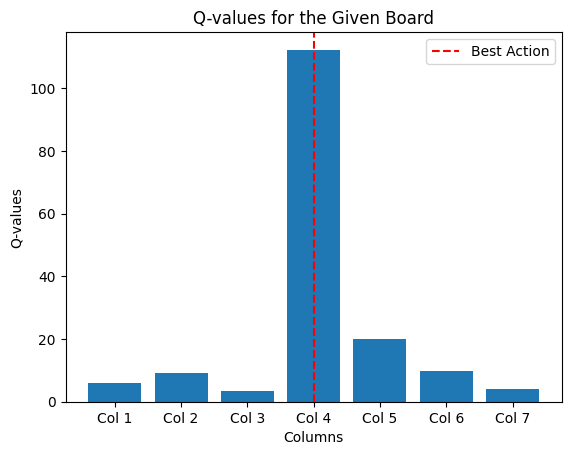

In [18]:
# Evaluate and visualize the board
state = '000000000000000000000000100000010000221200'

# Convert to numpy array and reshape into 6x7
board = np.array([int(cell) for cell in state]).reshape(6, 7)

visualize_q_values_for_board(agent,  board)